In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
import pandas as pd
torch.manual_seed(42)
torch.cuda.manual_seed(42)

import Figure_H2H_Regret

from Performance import performance_evaluation
perfs = performance_evaluation()

from Performance import H2h_Regret_Evaluation
h2h_regret_eva = H2h_Regret_Evaluation()

from Data import Data_Simulator
DS_Obj = Data_Simulator()

from Oracle import Oracle_Processing
Oracle_Proc = Oracle_Processing()

from OLS import OLS_Processing
OLS_Proc = OLS_Processing()

from DDR import DDR_Processing
DDR_Proc = DDR_Processing()

from PYEPO import EPO_Processing
PYEPO_Proc = EPO_Processing()

from Data_Load_Store import Load_Store_Methods
Data_LSM = Load_Store_Methods()

### Main functions

In [2]:
def run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process):
        
        x_test_all,c_test_all,x_train_all,c_train_all,noise_train_all,noise_test_all,W_star_all = Data_LSM.load_input_data(DataPath)

        cost_Oracle_Post_all,cost_Oracle_Ante_all = Oracle_Proc.Implement_Oracle(arcs, grid,mis,bump,\
                                                                    W_star_all,x_test_all,noise_test_all,\
                                                                    iteration_all,num_feat,data_generation_process)
        
        cost_OLS_Post_all,cost_OLS_Ante_all = OLS_Proc.Implement_OLS(arcs, grid,mis,bump,\
                                                            W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,\
                                                            iteration_all,num_feat,data_generation_process)

        cost_DDR_Post_all,cost_DDR_Ante_all = DDR_Proc.Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,\
                                                                    W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,\
                                                                        iteration_all,num_feat,data_generation_process)

        Data_LSM.store_Oracle_OLS_DDR_Cost(DataPath,cost_Oracle_Post_all,cost_Oracle_Ante_all,\
                                  cost_OLS_Post_all,cost_OLS_Ante_all,\
                                  cost_DDR_Post_all,cost_DDR_Ante_all)

In [3]:
def run_EPO_approaches(DataPath,method_names,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process):
        
        x_test_all,c_test_all,x_train_all,c_train_all,noise_train_all,noise_test_all,W_star_all = Data_LSM.load_input_data(DataPath)

        batch_size = 20
        num_epochs = 1000
        # from PYEPO import PyEPO_Method
        # epo_runner = PyEPO_Method()
        method_names = ["spo+"]
        cost_EPO_Post_all,cost_EPO_Ante_all = PYEPO_Proc.Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,\
                                                    W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                                                    arcs,grid,perfs,num_feat,mis,data_generation_process)

        with open(DataPath+'cost_'+method_names[0]+'_Post_all.pkl', "wb") as tf:
            pickle.dump(cost_EPO_Post_all,tf)
        with open(DataPath+'cost_'+method_names[0]+'_Ante_all.pkl', "wb") as tf:
            pickle.dump(cost_EPO_Ante_all,tf)

## Parameters

In [4]:
num_train = 100 # number of training data
num_feat = 5 # size of feature
num_test = 1000
deg = 1.0 # polynomial degree
e = 0.5 # scale of normal std or the range of uniform. For the error term

lower = 0 # coef lower bound
upper = 1 # coef upper bound
p = num_feat # num of features
alpha = e # scale of normal std or the range of uniform. For the error term
mis = deg # model misspecification
coef_seed = 1

x_dist = 'uniform'
e_dist = 'normal'
x_low = -2
x_up = 2
x_mean = 2
x_var = 2
bump = 100

data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"
iteration_all = np.arange(0,100)

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(parent_directory)))

### Network

In [5]:
grid_all = [(2,2),(3,3),(4,4),(5,5)]
middle_path = '/Data_JOC_R1/Shortest_Path/Baseline_' + data_generation_process +"/"
Result_dir = project_directory + middle_path + "Result/"
pathlib.Path(Result_dir).mkdir(parents=True, exist_ok=True)

In [6]:
x_test_grid = {}; c_test_grid = {}; x_train_grid = {}; c_train_grid = {}; noise_train_grid = {}; noise_test_grid = {}; W_star_grid = {}
for grid in grid_all:
    L_N = grid[0]
    d = (L_N - 1) * (L_N - 1) * 2 + 2 * (L_N - 1) # num of arcs
    num_nodes = L_N*L_N

    DataPath_parent = project_directory + middle_path +str(L_N)+'by'+str(L_N)+'_grid/'
    DataPath = DataPath_parent + f"data_size={num_train}_deg={deg}_e={e}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
    pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
    print("DataPath:", DataPath)

    x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all = \
    DS_Obj.Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

    Data_LSM.store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_SPO_Data_Generation/2by2_grid/data_size=100_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_SPO_Data_Generation/4by4_grid/data_size=100_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_SPO_Data_Generation/5by5_grid/data_size=100_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/


In [7]:
mu_all = np.round(np.arange(0.2,1.0,0.05),4)
lamb_all = np.round(np.arange(0.2,1.0,0.05),4)

cost_Oracle_Post_all = {}; cost_Oracle_Ante_all = {}
cost_OLS_Post_all = {}; cost_OLS_Ante_all = {}
cost_DDR_Post_all = {}; cost_DDR_Ante_all = {}

for grid in grid_all:
    from Network import network_design
    Network = network_design()
    arcs,arc_index_mapping = Network._getArcs(grid)

    L_N = grid[0]
    d = (L_N - 1) * (L_N - 1) * 2 + 2 * (L_N - 1) # num of arcs
    num_nodes = L_N*L_N

    DataPath_parent = project_directory + middle_path +str(L_N)+'by'+str(L_N)+'_grid/'
    DataPath = DataPath_parent + f"data_size={num_train}_deg={deg}_e={e}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
    print("DataPath:", DataPath)

    run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

    # method_names = ["spo+"]
    # run_EPO_approaches(DataPath,method_names,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_SPO_Data_Generation/2by2_grid/data_size=100_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
Oracle: iter= 20 ,cost_Oracle_Ante= 7.636899840033395
Oracle: iter= 40 ,cost_Oracle_Ante= 7.709997556944255
Oracle: iter= 60 ,cost_Oracle_Ante= 7.7524276049541685
Oracle: iter= 80 ,cost_Oracle_Ante= 7.5811517962362505
OLS: iter= 20 ,cost_OLS_Ante= 7.64772533514242
OLS: iter= 40 ,cost_OLS_Ante= 7.792749341506423
OLS: iter= 60 ,cost_OLS_Ante= 7.794495197048333
OLS: iter= 80 ,cost_OLS_Ante= 7.604090181960109
DDR: iter= 20 ,mu= 0.95 ,lamb= 0.95 ,cost_DDR_Ante = 7.648156054092254
DDR: iter= 40 ,mu= 0.95 ,lamb= 0.95 ,cost_DDR_Ante = 7.792749341506423
DDR: iter= 60 ,mu= 0.95 ,lamb= 0.95 ,cost_DDR_Ante = 7.794955470104525
DDR: iter= 80 ,mu= 0.95 ,lamb= 0.95 ,cost_DDR_Ante = 7.604270755346454
DataP

### Comparison

##### DDR vs OLS

In [17]:
h2h_ddr_vs_ols_ante = {}; cost_rd_ddr_vs_ols_ante = {}; regret_rd_ddr_vs_ols_ante = {}
h2h_ddr_vs_spo_ante = {}; cost_rd_ddr_vs_spo_ante = {}; regret_rd_ddr_vs_spo_ante = {}

for grid in grid_all:
    L_N = grid[0]

    DataPath_parent = project_directory + middle_path +str(L_N)+'by'+str(L_N)+'_grid/'
    DataPath = DataPath_parent + f"data_size={num_train}_deg={deg}_e={e}_num_test={num_test}"+"_x_dist="+x_dist+"_e_dist="+e_dist+"/"
    print("DataPath:", DataPath)     

    cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
    
    # with open(DataPath+'cost_spo+_Ante_all.pkl', "rb") as tf:
    #     cost_SPO_Ante_all = pickle.load(tf)
    for mu in mu_all:
        for lamb in lamb_all:
            h2h_ddr_vs_ols_ante[L_N,mu,lamb],regret_rd_ddr_vs_ols_ante[L_N,mu,lamb] \
                = h2h_regret_eva.calculate_DDR_vs_Others_h2h_regret(mu,lamb,iteration_all,\
                                                                    cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)

            # h2h_ddr_vs_spo_ante[L_N,mu,lamb],regret_rd_ddr_vs_spo_ante[L_N,mu,lamb] \
            #     = h2h_regret_eva.calculate_DDR_vs_Others_h2h_regret(mu,lamb,iteration_all,\
            #                                                         cost_DDR_Ante_all,cost_SPO_Ante_all,cost_Oracle_Ante_all)

    print("Grid = ",grid)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_SPO_Data_Generation/2by2_grid/data_size=100_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
Grid =  (2, 2)
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_SPO_Data_Generation/3by3_grid/data_size=100_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
Grid =  (3, 3)
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_SPO_Data_Generation/4by4_grid/data_size=100_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
Grid =  (4, 4)
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Shortest_Path/Baseline_SPO_Data_Generation/5by5_grid/data_size=100_deg=1.0_e=0.5_num_test=1000_x_dist=uniform_e_dist=normal/
Grid =  (5, 5)


In [ ]:
for grid in grid_all:
    L_N = grid[0]
    regret_mat = np.zeros((len(mu_all),len(lamb_all)))
    h2h_mat = np.zeros((len(mu_all),len(lamb_all)))
    mu_index = 0
    for mu in mu_all:
        lamb_index = 0
        for lamb in lamb_all:
            regret_rd_ = regret_rd_ddr_vs_ols_ante[L_N,mu,lamb]
            h2h_ = h2h_ddr_vs_ols_ante[L_N,mu,lamb]
            # regret_mat[mu_index,lamb_index] = np.round(np.mean(regret_rd_ddr_vs_ols_ante[L_N,mu,lamb]) * 100,2)

            regret_mat[mu_index,lamb_index] = np.round( len(regret_rd_[regret_rd_ > 0.0])/len(regret_rd_),6)
            h2h_mat[mu_index,lamb_index] = np.round( len(h2h_[h2h_ > 0.5])/len(h2h_),6 )

            lamb_index = lamb_index + 1
        mu_index = mu_index + 1
    regret_df = pd.DataFrame(regret_mat)
    regret_df.index = mu_all
    regret_df.columns = lamb_all
    regret_df.to_csv(Result_dir + f"Regret_DDR_vs_OLS_Ante_{L_N}by{L_N}_grid.csv")
    
    h2h_df = pd.DataFrame(h2h_mat)
    h2h_df.index = mu_all
    h2h_df.columns = lamb_all
    h2h_df.to_csv(Result_dir + f"H2h_DDR_vs_OLS_Ante_{L_N}by{L_N}_grid.csv")    

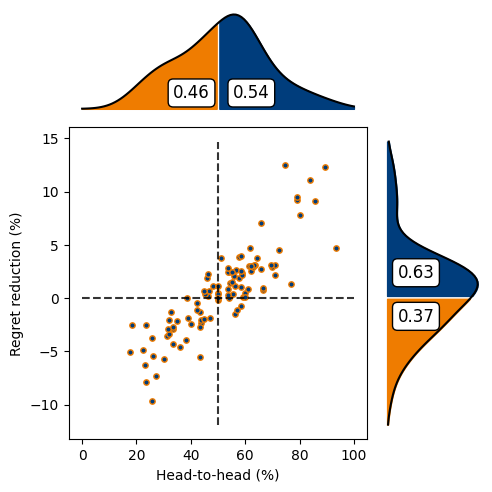

In [174]:
L_N = 3
mu = 0.75
lamb = 0.8
file_name = Result_dir + 'DDR_vs_OLS_mu='+str(mu)+"_lamb="+str(lamb)+"_ante_grid="+str(L_N)
all_x = h2h_ddr_vs_ols_ante[L_N,mu,lamb] * 100
all_y = regret_rd_ddr_vs_ols_ante[L_N,mu,lamb] * 100
Figure_H2H_Regret.figure_plot_upright(all_x, all_y, file_name, size = (5, 5), move = [-0.07, 0.07, 0.35, 0.55], ysame = 0, yrange = [6,6], sublabel = '', ypio = 0)

In [10]:
# mu = 0.8
# lamb = 0.5
# file_name = Result_dir + 'DDR_vs_SPO_mu='+str(mu)+"_lamb="+str(lamb)+"_post_grid="+str(L_N)
# all_x = h2h_ddr_vs_spo_ante[L_N,mu,lamb] * 100
# all_y = regret_rd_ddr_vs_spo_ante[L_N,mu,lamb] * 100
# Figure_H2H_Regret.figure_plot_upright(all_x, all_y, file_name, size = (5, 5), move = [-0.07, 0.07, 0.35, 0.55], ysame = 0, yrange = [6,6], sublabel = '', ypio = 0)

#### Impact of network size

In [155]:
def obtain_DDR_vs_OLS_Network_Result(grid_all,mu_all,lamb_all,h2h_ddr_vs_ols_input,regret_rd_ddr_vs_ols_input):
    h2h_avg_all = {}; regret_rd_avg_all = {}
    h2h_prop_all = {}; regret_rd_prop_all = {}

    for grid in grid_all:
        L_N = grid[0]
        h2h_avg = np.zeros((len(mu_all),len(lamb_all))); regret_rd_avg = np.zeros((len(mu_all),len(lamb_all)))
        h2h_prop = np.zeros((len(mu_all),len(lamb_all))); regret_rd_prop = np.zeros((len(mu_all),len(lamb_all)))

        mu_index = 0
        for mu in mu_all:
            lamb_index = 0
            for lamb in lamb_all:
                h2h_ddr_ols_tem = h2h_ddr_vs_ols_input[L_N,mu,lamb]
                regret_rd_ddr_vs_ols_tem = regret_rd_ddr_vs_ols_input[L_N,mu,lamb]

                h2h_avg[mu_index,lamb_index] = np.nanmean(h2h_ddr_ols_tem)
                regret_rd_avg[mu_index,lamb_index] = np.nanmean(regret_rd_ddr_vs_ols_tem)
                
                h2h_prop[mu_index,lamb_index] = len(h2h_ddr_ols_tem[h2h_ddr_ols_tem >= 0.5])/len(h2h_ddr_ols_tem)
                regret_rd_prop[mu_index,lamb_index] = len(regret_rd_ddr_vs_ols_tem[regret_rd_ddr_vs_ols_tem > 0.0])/len(regret_rd_ddr_vs_ols_tem)
        
                lamb_index = lamb_index + 1
            mu_index = mu_index + 1

        h2h_avg_all[L_N] = h2h_avg
        regret_rd_avg_all[L_N] = regret_rd_avg
        h2h_prop_all[L_N] = h2h_prop
        regret_rd_prop_all[L_N] = regret_rd_prop

    return h2h_avg_all,regret_rd_avg_all,h2h_prop_all,regret_rd_prop_all

In [156]:
h2h_ddr_vs_ols_ante_avg_all,regret_rd_ddr_vs_ols_ante_avg_all,h2h_ddr_vs_ols_ante_prop_all,regret_rd_ddr_vs_ols_ante_prop_all = \
    obtain_DDR_vs_OLS_Network_Result(grid_all,mu_all,lamb_all,h2h_ddr_vs_ols_ante,regret_rd_ddr_vs_ols_ante)

In [157]:
regret_avg_max_ante = np.zeros(len(grid_all)); regret_avg_max_indices_ante = {}
regret_prop_max_ante = np.zeros(len(grid_all)); regret_prop_max_indices_ante = {}

grid_index = 0
for grid in grid_all:
    L_N = grid[0]

    regret_avg_max_ante[grid_index] = np.max(regret_rd_ddr_vs_ols_ante_avg_all[L_N]) * 100
    max_index = np.unravel_index(np.argmax(regret_rd_ddr_vs_ols_ante_avg_all[L_N]), regret_rd_ddr_vs_ols_ante_avg_all[L_N].shape)
    regret_avg_max_indices_ante[grid[0]] = (mu_all[max_index[0]],lamb_all[max_index[1]])

    regret_prop_max_ante[grid_index] = np.max(regret_rd_ddr_vs_ols_ante_prop_all[L_N]) * 100
    max_index = np.unravel_index(np.argmax(regret_rd_ddr_vs_ols_ante_prop_all[L_N]), regret_rd_ddr_vs_ols_ante_prop_all[L_N].shape)
    regret_prop_max_indices_ante[grid[0]] = (mu_all[max_index[0]],lamb_all[max_index[1]])

    grid_index = grid_index + 1

In [158]:
from scipy.stats import gaussian_kde
from matplotlib import gridspec
import seaborn as sns
import matplotlib.pyplot as plt

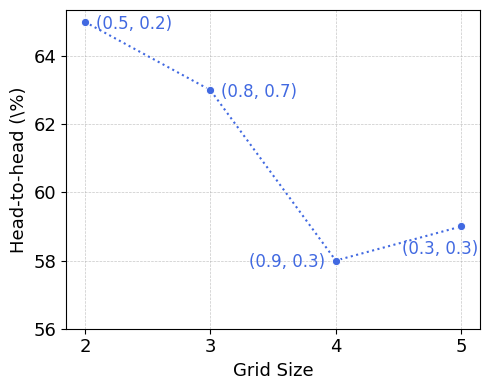

In [179]:
ticksize = 13
labelsize = 13
legendsize = 13

grid_sizes = [grid[0] for grid in grid_all]

plt.figure(figsize=(5, 4))
sns.set_palette("tab10")  # Enhanced color palette
custom_colors = ['#D93B3C', 'royalblue', '#4F207F', '#EFAB02']
markers = ["o","X","s","d"]

sns.lineplot(x=grid_sizes, y=regret_prop_max_ante,marker=markers[0], color=custom_colors[1], linestyle=':')

# plt.title('Change of Values by Sample Size and Varphi')
plt.xlabel('Grid Size', fontsize = labelsize)
plt.ylabel('Head-to-head (\%)', fontsize = labelsize)

xytext_psotion = [(35, -5),(35, -5),(-35, -5),(-15, -20)]
for i, size in enumerate(grid_sizes):
    x_offset, y_offset = regret_prop_max_indices_ante[size]
    plt.annotate(f"({x_offset:.1f}, {y_offset:.1f})",
                 (size, regret_prop_max_ante[i]),
                 textcoords="offset points",
                 xytext=xytext_psotion[i],
                 ha='center',
                 fontsize=12,
                 color=custom_colors[1])

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks([2, 3, 4, 5], fontsize=ticksize)
plt.yticks(np.arange(56,66,2), fontsize=ticksize)

plt.tight_layout()  # Automatically adjust subplot params to give specified padding
plt.savefig(Result_dir +"Impact_Network_Structure_Ante_on_H2H.pdf", format='pdf')

plt.show()

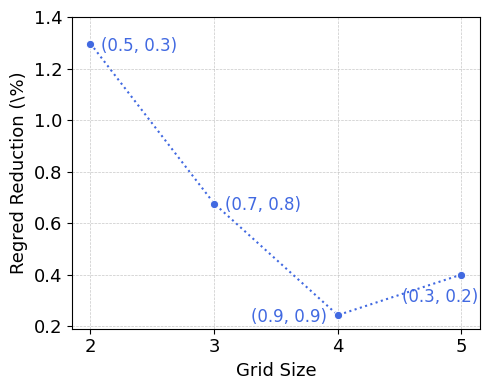

In [180]:
ticksize = 13
labelsize = 13
legendsize = 13
grid_sizes = [grid[0] for grid in grid_all]

plt.figure(figsize=(5, 4))
sns.set_palette("tab10")  # Enhanced color palette
custom_colors = ['#D93B3C', 'royalblue', '#4F207F', '#EFAB02']
markers = ["o","X","s","d"]

sns.lineplot(x=grid_sizes, y=regret_avg_max_ante,marker=markers[0], color=custom_colors[1], linestyle=':')

# plt.title('Change of Values by Sample Size and Varphi')
plt.xlabel('Grid Size', fontsize = labelsize)
plt.ylabel('Regred Reduction (\%)', fontsize = labelsize)

xytext_psotion = [(35, -5),(35, -5),(-35, -5),(-15, -20)]
for i, size in enumerate(grid_sizes):
    x_offset, y_offset = regret_avg_max_indices_ante[size]
    plt.annotate(f"({x_offset:.1f}, {y_offset:.1f})",
                 (size, regret_avg_max_ante[i]),
                 textcoords="offset points",
                 xytext=xytext_psotion[i],
                 ha='center',
                 fontsize=12,
                 color=custom_colors[1])

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks([2, 3, 4,5], fontsize=ticksize)
plt.yticks([0.2, 0.4, 0.6,0.8,1.0,1.2,1.4], fontsize=ticksize)

plt.tight_layout()  # Automatically adjust subplot params to give specified padding
plt.savefig(Result_dir +"Impact_Network_Structure_Ante_on_Regret_Rd.pdf", format='pdf')

plt.show()